In [1]:
import pyodbc as pyodbc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

DB_SERVER = '192.168.9.64'
DB_PORT = '1433'
DB_NAME = 'ReplCS'
DB_USER = 'soporte_cierre'
DB_PASSWORD = '12345678%'

connStr = ('DRIVER={ODBC Driver 17 for SQL Server};Server=%s,%s;port=%s;Database=%s;uid=%s;pwd=%s') \
         % (DB_SERVER, DB_PORT, DB_PORT, DB_NAME, DB_USER, DB_PASSWORD)
print(connStr)
cnxn = pyodbc.connect(connStr)
cursor = cnxn.cursor()
print(cnxn, cursor)
print(cursor.execute("SELECT @@SPID").fetchone())

DRIVER={ODBC Driver 17 for SQL Server};Server=192.168.9.64,1433;port=1433;Database=ReplCS;uid=soporte_cierre;pwd=12345678%
<pyodbc.Connection object at 0x7fc7733d0d30> <pyodbc.Cursor object at 0x7fc7728a8d50>
(122, )


In [2]:
import textwrap
sql = textwrap.dedent("""
select cust.name, ordr.cust_code, COUNT(1) as despachos
from ordr WITH(NOLOCK)
JOIN ordl WITH(NOLOCK) on   ordr.order_code=ordl.order_code 
						and ordr.order_date=ordl.order_date
JOIN schd WITH(NOLOCK) on  schd.order_date = ordl.order_date	
							AND schd.order_code = ordl.order_code 
							AND schd.order_intrnl_line_num = ordl.order_intrnl_line_num								
JOIN schl WITH(NOLOCK) ON  schd.order_date = schl.order_date 
							AND schd.order_code = schl.order_code 
							AND schd.order_intrnl_line_num = schl.order_intrnl_line_num	
							AND schd.sched_num = schl.sched_num
JOIN cust(nolock) on cust.cust_code = ordr.cust_code
where ordr.order_date = convert(date,getdate())
	AND (ordr.remove_rsn_code IS NULL OR ordr.remove_rsn_code = 'LIM')
	AND (schd.remove_rsn_code IS NULL OR schd.remove_rsn_code = 'LIM')
	AND (schl.remove_rsn_code IS NULL OR schl.remove_rsn_code = 'LIM')
	AND (RTRIM(LTRIM(ordl.prod_code)) <> '000015' AND RTRIM(LTRIM(ordl.prod_code)) <> '000735') /* codigo de servicio bombeo Unicon y Concremax */
	AND NOT(ordr.stat = '4')	
	AND (/* Solo concreto */
		schd.truck_type NOT IN ('TK','BP','BE') AND 
		schd.truck_type IS NOT NULL AND 
		RTRIM(LTRIM(ordl.short_prod_descr)) <> 'PROGRAMACION DE'
	) /* Solo concreto */
group by cust.name, ordr.cust_code
order by 3 desc
""")

In [5]:
num_list = 20
df = pd.read_sql(sql, cnxn)
df.head(num_list)

name   cust_code  despachos
0   CONSORCIO HV- DVC                         043877            143
1   CONSTRUCTORA MTL E.I.R.L.                 023779             72
2   HV CONTRATISTAS S. A.                     000091             52
3   CONSORCIO SANTA ROSA                      045271             45
4   CONSTRUCTORA INARCO PERU S.A.C.           021954             41
5   COSAPI S.A.                               000149             37
6   CONSORCIO CONSTRUCTOR M2 LIMA             031901             37
7   J.E. CONSTRUCCIONES GENERALES S.A.        003115             36
8   SEVILLA RODRIGUEZ S.R.L.                  004410             36
9   CONSORCIO CONSTRUCTOR LIMA 2019           045291             33
10  WESCON INGENIERIA Y CONSTRUCCION SAC      036116             32
11  CONSORCIO VIRGEN DEL CARMEN               045111             28
12  C Y J CONSTRUCTORES Y CONTRATISTAS S.A.C  011237             28
13  ESPARQ CIESA CONTRATISTAS GENERALES S.A.  000711             24
14  INMOBILIARIA SAN DIEGO DE ALCALA S.A.C.   040072             22
15  OBRAS SUBTERRANEAS S.A. SUCURSAL EN LA R  034494             20
16  BESCO  S.A.C.                             006640             20
17  G Y M S.A.                                000177             16
18  INVERSIONES INMOBILIARIAS DEL INDICO S.A  045097             16
19  SERVICIOS GENERALES JHAN MARCO E.I.R.L    008426             15

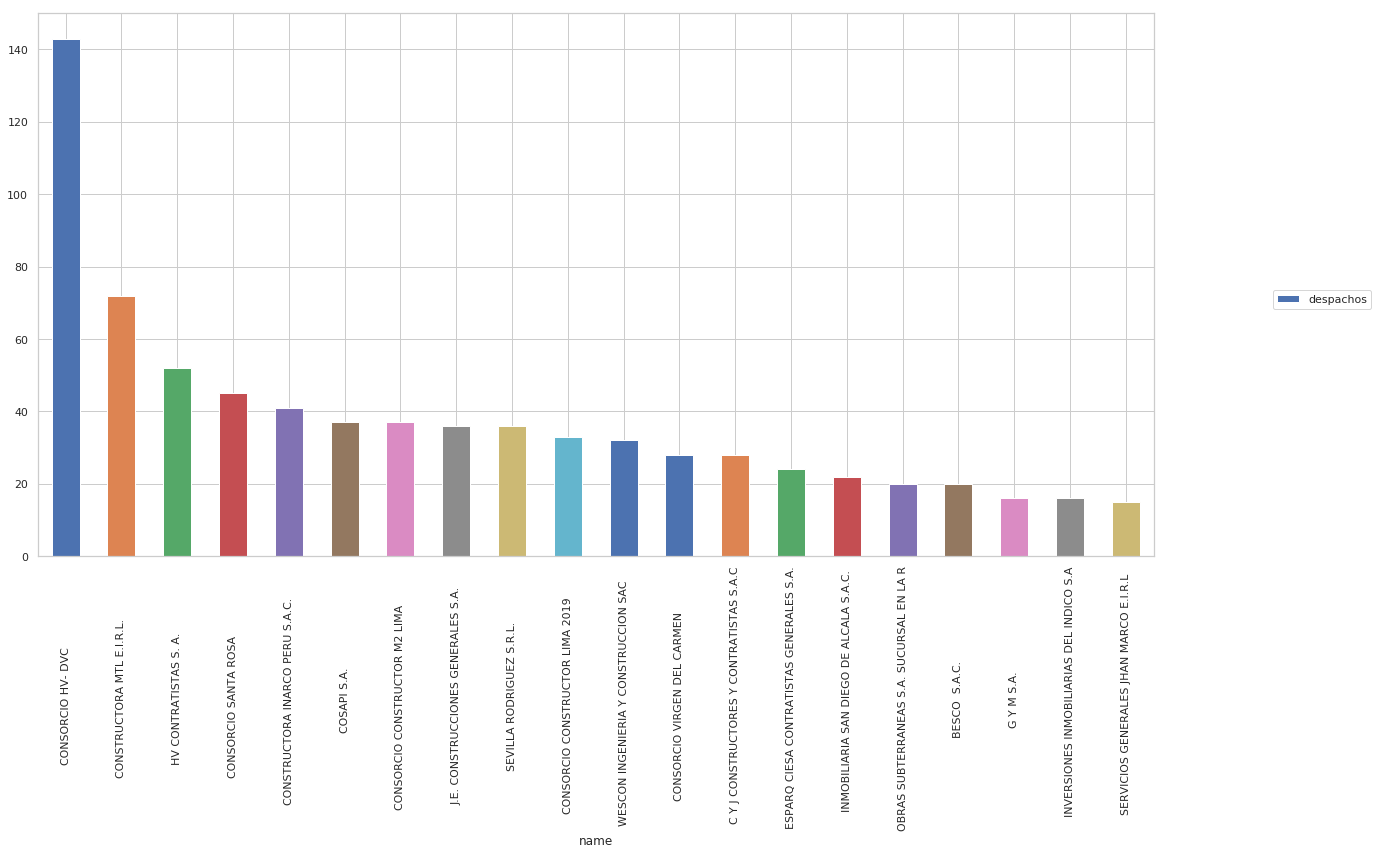

In [6]:
sns.set(style="whitegrid")
ax = df.head(num_list).plot.bar(x='name', y='despachos', rot=0, figsize=(20,10)).legend(bbox_to_anchor=(1.2, 0.5))
plt.xticks(df.head(num_list).index, df.head(num_list)['name'], rotation='vertical')
plt.show()